In [1]:
import numpy as np
import cv2
from PIL import Image
import pandas as pd
from skimage.io import imsave,imread,imshow,show
import matplotlib.pyplot as plt
from tqdm import tqdm
import trackpy as tp
import seaborn
import tifffile as tiff

c:\Users\mriza\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Helper Functions

In [14]:
def load_tif(filename, show=True):

    # read image using your favorite package
    tif_file = imread(filename)
    im=tif_file[0,:,:]

    if show:
        im_inverted=np.invert(im)
        imshow(im_inverted)
        plt.title("First segmented frame of the video")
        plt.show()
    return tif_file

def contour_fitting(tif_file, show_nth_frame=None):

    tif_dimension=tif_file.ndim
    
    if tif_dimension==3:
        if show_nth_frame is not None:
            nthframe=tif_file[show_nth_frame,:,:]
            img_where=np.where(nthframe==0)
            blank_image = np.zeros((nthframe.shape[0],nthframe.shape[1],3), np.uint8)
                    
            for i in range(0, len(img_where[0])):
                blank_image[img_where[0][i]][img_where[1][i]]=(255,255,255)
                
        cnt_image=blank_image

        contours_list=[]
        for nframe in tqdm(range(0, tif_file.shape[0]), desc="Finding the contour of the bacteria..."):
            frame=tif_file[nframe]
            frame=frame.astype(np.uint8)
            
            #print(np.shape(blank_image))

            #Detecting contours of the bacteria
            contours, _ = cv2.findContours(frame, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            contours_list.append(contours)

            #Drawing the contours in red
            if show_nth_frame is not None and nframe==show_nth_frame:

                cv2.drawContours(cnt_image, contours, -1, (255,0,0), 1)

        if show_nth_frame is not None:
                plt.imshow(cnt_image)
                plt.title("Bacterial contours drawn on the " + str(show_nth_frame)+"th image")
                plt.show()
        #print(len(contours_list))
        return contours_list
    else:
        raise ValueError("Shape of the tif file should be (# of frames, dim_x, dim_y)")
        
    
def fit_ellipses(tif_file, contours=None, filter_max=None, show_nth_frame=None, debug=False):
    
    if contours is None:
        contours=contour_fitting(tif_file, show_nth_frame=show_nth_frame)

    if show_nth_frame is not None:
        nthframe=tif_file[show_nth_frame,:,:]
        img_where=np.where(nthframe==0)
        blank_image = np.zeros((nthframe.shape[0],nthframe.shape[1],3), np.uint8)
                
        for i in range(0, len(img_where[0])):
            blank_image[img_where[0][i]][img_where[1][i]]=(255,255,255)
                
        ellipse_image=blank_image

    tif_dimension=tif_file.ndim
    
    if tif_dimension==3:
        
        ellipses_all_frames=[]
        for nframe in tqdm(range(0, tif_file.shape[0]), "Fitting ellipses to the contours..."):
            mistreated_ellipses=0
            ellipses=[]

            for j in range(0, len(contours[nframe])):   
                
                try:
                    #Fitting an elipse to the bacteria contours
                    ellipse = cv2.fitEllipse(contours[nframe][j])
                    if filter_max is not None and not(1<ellipse[1][0]<filter_max[0] and 1<ellipse[1][1]<filter_max[1]):
                        raise Exception("Filtering...")
                    else:
                        ellipses.append(ellipse)

                except Exception as e:
                    if(debug):
                        print(e)
                        mistreated_ellipses+=1
            
                if nframe==show_nth_frame and len(ellipses)!=0:
                    cv2.ellipse(ellipse_image,ellipse, (0,0,255), 1)

            if debug:
                print("Number of undetected ellipses: "+ str(mistreated_ellipses)+ " , in frame: "+str(nframe))

            ellipses_all_frames.append(ellipses)
        if show_nth_frame is not None:
                plt.imshow(ellipse_image)
        return ellipses_all_frames
    else:
        raise ValueError("Shape of the tif file should be (# of frames, dim_x, dim_y)")
    
def format_ellipses(ellipses_df):
    all_ellipses = [(frame_idx, ellipse) for frame_idx, frame in enumerate(ellipses_df) for ellipse in frame]

    #We then put it in a pandas dataframe
    ellipses_df = pd.DataFrame({
        'x': [ellipse[0][0] for _, ellipse in all_ellipses],
        'y': [ellipse[0][1] for _, ellipse in all_ellipses],
        'frame': [frame_idx for frame_idx, _ in all_ellipses],
        'major_axis_size': [ellipse[1][1] for _, ellipse in all_ellipses], #length of major axis
        'minor_axis_size': [ellipse[1][0] for _, ellipse in all_ellipses], #length of major axis
        'body_angle': [ellipse[2] for _, ellipse in all_ellipses], #alignment angle of the ellipse
        
    })

    ellipses_df=ellipses_df.dropna()
    return ellipses_df

def ellipse_to_particle(tif_file, file_name, ellipses_df):

    output_path=file_name[:-4]+str("_particle.tif")
    image_to_save=[]
    ellipses_group=ellipses_df.groupby("frame")
    
    for nframe, group in tqdm(ellipses_group, "Converting ellipses to particles"):
        blank_image = np.zeros((tif_file.shape[1],tif_file.shape[2],3), np.uint8)
        
        for index, row in group.iterrows():
            x = int(row['x'])
            y = int(row['y'])
            cv2.circle(blank_image, (x,y), radius=3, color=(255, 255, 255), thickness=-1)

        image_to_save.append(Image.fromarray(blank_image))

    image_to_save[0].save(output_path, save_all=True, append_images=image_to_save[1:], compression='tiff_deflate')
    

def track_bacteria(ellipses_df, max_search_range=20, min_search_range=10, filter=None):
    traj_tp = tp.link_df(ellipses_df, 
                  search_range = max_search_range, 
                  adaptive_stop = min_search_range,
                  adaptive_step=0.98, 
                  memory = 0)
    traj_tp = traj_tp.sort_values(by=['particle', 'frame'])

    traj_tp.reset_index(drop=True, inplace=True)
    
    if filter is not None:
        traj_tp=filter_trajectories(traj_tp,filter_size=filter)

    return traj_tp
        
def filter_trajectories(trajectory, filter_size=100):
    
    particle_counts = trajectory['particle'].value_counts()
    particles_to_keep = particle_counts[particle_counts > filter_size].reset_index().rename(columns={'index': 'particle', 'particle': 'count'})
    display(particles_to_keep)
    trajectory_filtered = pd.merge(trajectory, particles_to_keep[['particle']], on='particle')

    return trajectory_filtered



#We take this function from a python package called pytaxis: https://github.com/tatyana-perlova/pytaxis
def plot_traj_all(traj,
                imdim1,
                imdim2,
                pix_size, 
                palette = None, 
                scalebar = 100):

    if palette == None:
        palette = seaborn.color_palette("Dark2", len(traj.particle.unique()))
    plt.tick_params(\
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',
        left = 'off',
        right = 'off',# ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off') # labels along the bottom edge are off
    plt.yticks([])
    plt.xticks([])
    plt.xlim(0, imdim1)
    plt.ylim(0, imdim2)
    
    
    unstacked = traj.set_index(['frame', 'particle']).unstack()
    plot = plt.plot(unstacked.x, unstacked.y, linewidth=2, alpha = 1)
    plt.gca().set_aspect(1)
    plt.plot([1600, 1600 + scalebar/pix_size], [1800 , 1800], color = 'black', linewidth = 4)
    plt.text(1550, 1850, r'{}$\mu m$'.format(scalebar), fontsize = 18)

def calculate_kinematic_parameters(trajectory_data, time_window=1):
    
    def group_parameters(traj_group,time_step=time_window):
        
        # If time_step is set to 1, it will calculate the displacement parameters of particles in 2 consecutive frames

        # Calculate velocities
        traj_group['vx'] = traj_group['x'].diff() / time_step
        traj_group['vy'] = traj_group['y'].diff() / time_step
        traj_group['vel']=np.sqrt(traj_group['vx']**2 + traj_group['vy']**2)

        # Calculate accelerations
        traj_group['ax'] = traj_group['vx'].diff() / time_step
        traj_group['ay'] = traj_group['vy'].diff() / time_step
        traj_group['acc']=np.sqrt(traj_group['ax']**2 + traj_group['ay']**2)

        # Calculate angular position
        traj_group['angle'] = np.arctan2(traj_group['vy'], traj_group['vx'])

        # Calculate angular velocity
        traj_group['angular_vel'] = traj_group['angle'].diff() / time_step

        # Calculate angular acceleration
        traj_group['angular_acc'] = traj_group['angular_vel'].diff() / time_step

        return traj_group

    traj_params = trajectory_data.groupby('particle', group_keys=True).apply(group_parameters)
    traj_params.reset_index(drop=True, inplace=True)

    return traj_params

# Load the data

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


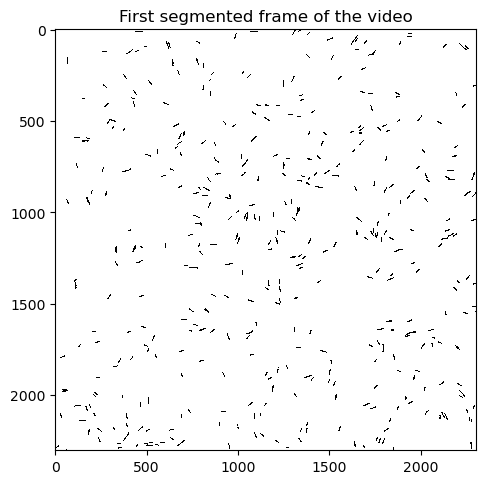

2304 2304


In [3]:
file_name="pilH_dense_mSc.tif"
im=load_tif(file_name, show=True)
tifdim1=im.shape[1]
tifdim2=im.shape[2]
print(tifdim1, tifdim2)

# Fit ellipses to the contours

Finding the contour of the bacteria...: 100%|██████████| 200/200 [00:01<00:00, 196.34it/s]


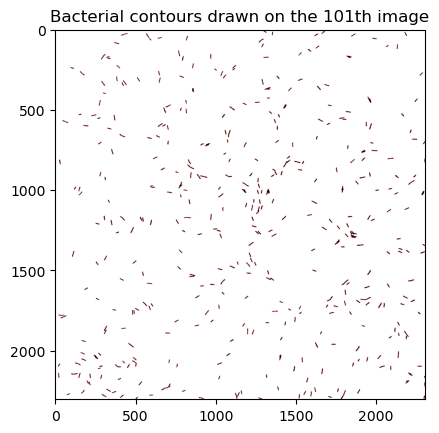

Fitting ellipses to the contours...: 100%|██████████| 200/200 [00:00<00:00, 253.64it/s]


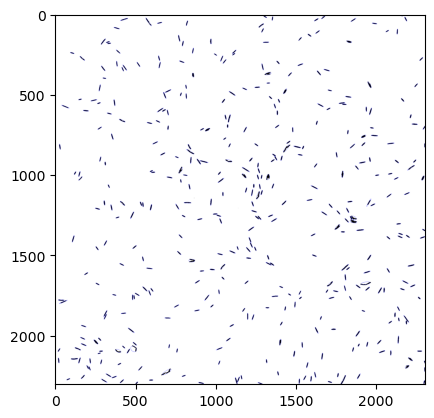

In [4]:
fitted_ellipses=fit_ellipses(im, show_nth_frame=101, filter_max=(20,100))

# Format the data and plot the distribution of alignment angles

,x,y,frame,major_axis_size,minor_axis_size,body_angle
0,63.335365,2300.847656,0,13.432899,5.698264,47.701675
1,1852.221069,2297.835693,0,16.904724,5.823165,8.277697
2,1271.914307,2289.281006,0,24.360962,5.967599,82.002548
3,355.131378,2290.897705,0,29.223640,5.812747,77.162697
4,7.650183,2290.168213,0,39.926300,6.018880,52.164131
...,...,...,...,...,...,...
81645,2263.331055,6.550769,199,19.678921,4.981118,135.646927
81646,1670.389282,6.873578,199,33.062607,3.928048,57.323318
81647,1379.774292,6.470076,199,34.700546,4.631261,156.559418
81648,1097.357910,9.621296,199,26.105391,5.557971,8.183462


Converting ellipses to particles: 100%|██████████| 200/200 [00:04<00:00, 43.31it/s]


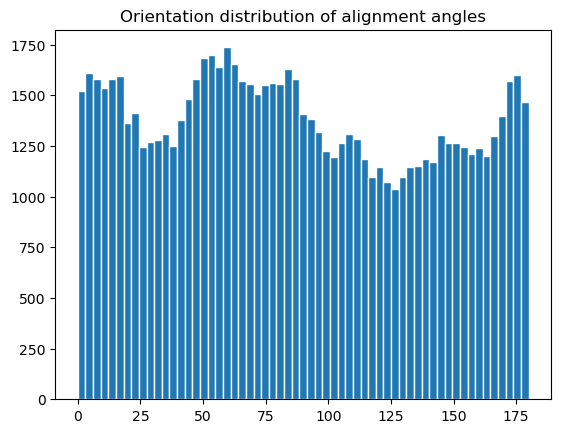

In [15]:
#format the fitted ellipses into a dataframe for tracking
ellipses_df=format_ellipses(fitted_ellipses)
display(ellipses_df)

#For PIV analysis, we transform ellipses into single points
ellipse_to_particle(im, file_name, ellipses_df)


plt.hist(ellipses_df["body_angle"], bins=59, histtype='bar', ec='white')

#This is just a demo not final
plt.title("Orientation distribution of alignment angles")
plt.show()


In [6]:
import trackpy.diag
trackpy.diag.performance_report()

Yes, but could it be faster?
FAST: numba is available and enabled (fast subnets and feature-finding).


# Track the bacteria

In [7]:
traj_tp = track_bacteria(ellipses_df, max_search_range=10, min_search_range=2)
display(traj_tp)

Frame 199: 424 trajectories present.


,x,y,frame,major_axis_size,minor_axis_size,body_angle,particle
0,63.335365,2300.847656,0,13.432899,5.698264,47.701675,0
1,63.376377,2299.443604,1,21.432013,6.460067,40.188511,0
2,64.805603,2298.151367,2,27.274609,6.336607,36.915421,0
3,67.410072,2294.255615,3,25.505547,6.137639,34.943344,0
4,69.994751,2292.359619,4,25.416754,6.442495,35.812584,0
...,...,...,...,...,...,...,...
81645,824.466675,870.935730,199,29.069426,5.306165,20.971075,1251
81646,820.946777,839.791565,199,28.893948,5.060101,160.521652,1252
81647,2297.367676,775.847107,199,8.969006,8.124840,175.056274,1253
81648,823.188660,1093.832153,199,35.268040,4.752950,67.711807,1254


In [8]:
filtered=filter_trajectories(traj_tp,50)

,particle,count
0,0,200
1,298,200
2,134,200
3,325,200
4,324,200
...,...,...
514,645,52
515,1012,51
516,1003,51
517,151,51


# Plot trajectories

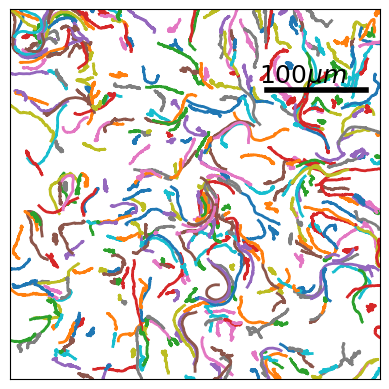

In [9]:
plot_traj_all(filtered, imdim1=tifdim1, imdim2=tifdim2, pix_size=0.1615)

# Calculate the kinematic parameters such as velocity and acceleration etc.

In [10]:
particle_params=calculate_kinematic_parameters(filtered)
display(particle_params)

,x,y,frame,major_axis_size,minor_axis_size,body_angle,particle,vx,vy,vel,ax,ay,acc,angle,angular_vel,angular_acc
0,63.335365,2300.847656,0,13.432899,5.698264,47.701675,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,63.376377,2299.443604,1,21.432013,6.460067,40.188511,0,0.041012,-1.404053,1.404652,NaN,NaN,NaN,-1.541595,NaN,NaN
2,64.805603,2298.151367,2,27.274609,6.336607,36.915421,0,1.429226,-1.292236,1.926801,1.388214,0.111816,1.392710,-0.735104,0.806491,NaN
3,67.410072,2294.255615,3,25.505547,6.137639,34.943344,0,2.604469,-3.895752,4.686165,1.175243,-2.603516,2.856482,-0.981497,-0.246393,-1.052885
4,69.994751,2292.359619,4,25.416754,6.442495,35.812584,0,2.584679,-1.895996,3.205521,-0.019791,1.999756,1.999854,-0.632891,0.348606,0.595000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72655,2092.708740,1302.017944,195,31.162880,6.151886,89.522423,1012,0.907227,0.513916,1.042674,-3.903076,-0.845337,3.993570,0.515400,0.240008,-0.016612
72656,2095.174561,1302.645508,196,32.016125,5.371504,90.230682,1012,2.465820,0.627563,2.544426,1.558594,0.113647,1.562732,0.249214,-0.266186,-0.506194
72657,2099.930908,1303.439087,197,29.693815,5.660843,89.851784,1012,4.756348,0.793579,4.822096,2.290527,0.166016,2.296536,0.165323,-0.083891,0.182295
72658,2102.148193,1303.965576,198,30.938530,5.813237,93.266502,1012,2.217285,0.526489,2.278935,-2.539062,-0.267090,2.553072,0.233130,0.067807,0.151697
